# Detection of modified images or videos using Neural Networks

## Importing the libraries

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os
import shutil
from kaggle.api.kaggle_api_extended import KaggleApi

## Downloading the dataset

In [41]:
URL = "sophatvathana/casia-dataset"
PATH_DATASET = './../dataset/'

def download_dataset():
    api = KaggleApi()
    api.authenticate()
    print("Downloading files...")
    api.dataset_download_files('sophatvathana/casia-dataset', path=PATH_DATASET, unzip=True)

    print("\rDownload complete.")


def clean_directory():
    print("Moving folder...")
    os.rename(PATH_DATASET+"CASIA2/Au", PATH_DATASET+"Au")
    os.rename(PATH_DATASET+"CASIA2/Tp", PATH_DATASET+"Tp")
    
    print("Cleaning directory...")
    shutil.rmtree(PATH_DATASET+"casia")
    shutil.rmtree(PATH_DATASET+"CASIA1")
    shutil.rmtree(PATH_DATASET+"CASIA2")
    os.remove(PATH_DATASET+"Tp/Thumbs.db")
    os.remove(PATH_DATASET+"Au/Thumbs.db")
    print("Cleaning complete.")

In [42]:
if not os.path.exists(PATH_DATASET+"Au"):
    download_dataset()
    clean_directory()
else:
    print("Dataset already Downloaded.")

Download complete.
Moving folder...
Cleaning directory...
Cleaning complete.


## Analyzing the dataset

### Creating function to analyze the dataset

In [43]:
REAL_IMAGE_PATH = '../dataset/Au'
FAKE_IMAGE_PATH = "../dataset/Tp"

def count_files(path: str) -> int:
    return len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])

#create a category for evry split by _ and add it to the list
def create_tampering_list(path: str, delimeter: int) -> list:
    category_list = []
    for file in os.listdir(path):
        category = file.split("_")
        for i in range(1, len(category)-delimeter):
            if category[i] not in category_list:
                category_list.append(category[i])
    return category_list

#count images in each category
def count_images_in_category(path: str, category: str) -> int:
    count = 0
    for file in os.listdir(path):
        if file.__contains__(category):
            count += 1
    return count

#count images in each category and add it to the dictionary
def create_category_dictionary(path: str) -> dict:
    dicc_categories = {}
    #category_list = create_category_list(path, delimeter)
    category_list = ["ani", "arc", "art", "cha", "nat", "pla", "sec", "txt"]
    for category in category_list:
        dicc_categories[category] = count_images_in_category(path, category)
    return dicc_categories

def create_trampering_dictionary(path: str) -> dict:
    dicc_trampering = {}
    for file in os.listdir(path):
        trampering = file.split("_")
        tram_region = trampering[1]
        tram_key = trampering[5][:3]

        if tram_key not in dicc_trampering:
            dicc_trampering[tram_key] = {tram_region: 1}
        else:
            if tram_region not in dicc_trampering[tram_key]:
                dicc_trampering[tram_key][tram_region] = 1
            else:
                dicc_trampering[tram_key][tram_region] += 1
    return dicc_trampering


#plot the dictionary
def plot_dictionary(dictionary: dict) -> None:
    plt.bar(range(len(dictionary)), list(dictionary.values()), align='center')
    plt.xticks(range(len(dictionary)), list(dictionary.keys()))
    plt.show()

def multiple_bar_plots(dictionary: dict) -> None:
    x = dictionary.keys()
    x_axis = np.arange(len(x))
    d = []
    s = []
    for key in x:
        d.append(dictionary[key]['D'])
        s.append(dictionary[key]['S'])

    plt.bar(x_axis - 0.2, d, 0.4, label='Different')
    plt.bar(x_axis + 0.2, s, 0.4, label='Same')
    
    plt.xticks(x_axis, x)
    plt.xlabel("Category")
    plt.ylabel("Number of images")
    plt.title("Tampering region by category")
    
    plt.legend()
    plt.show()


def show_image_from_category(path: str, dicc_categories: dict) -> None:
    rows = 4
    columns = 2
    fig = plt.figure(figsize=(10, 10))

    for i, category in enumerate(dicc_categories.keys()):
        for file in os.listdir(path):
            if category in file:
                img = Image.open(os.path.join(path, file))
                fig.add_subplot(rows, columns, i+1)
                plt.title(category)
                plt.imshow(img)
                plt.axis('off')
                break
    plt.show()

### Analyzing the real images

Number of real images:  7491
Number of categories:  8


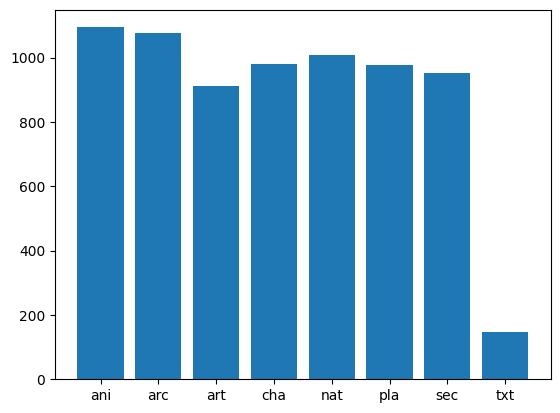

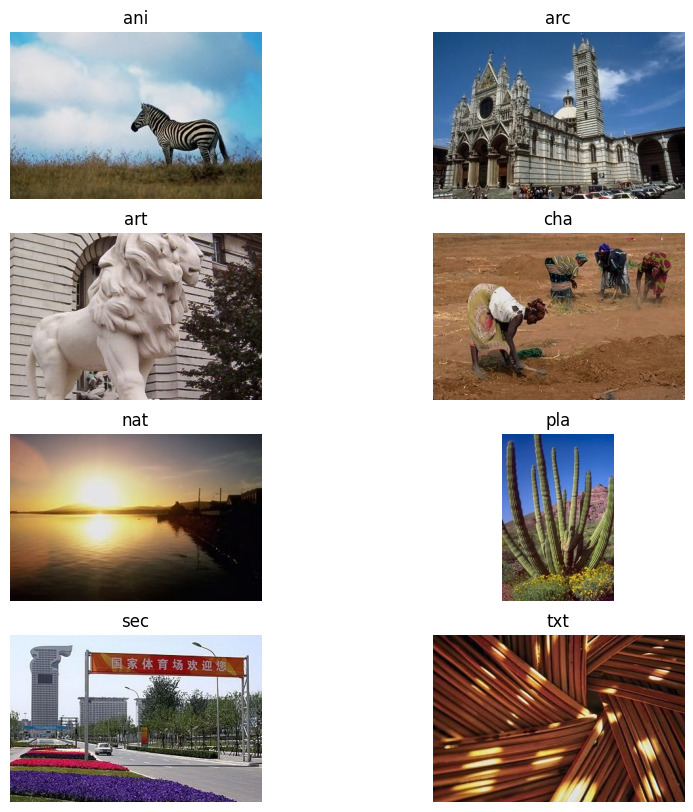

In [44]:
dicc_real = create_category_dictionary(REAL_IMAGE_PATH)

print("Number of real images: ", count_files(REAL_IMAGE_PATH))
print("Number of categories: ", len(dicc_real))
plot_dictionary(dicc_real)

show_image_from_category(REAL_IMAGE_PATH, dicc_real)

### Analyzing the fake images

Number of fake images:  5123
Number of categories:  8


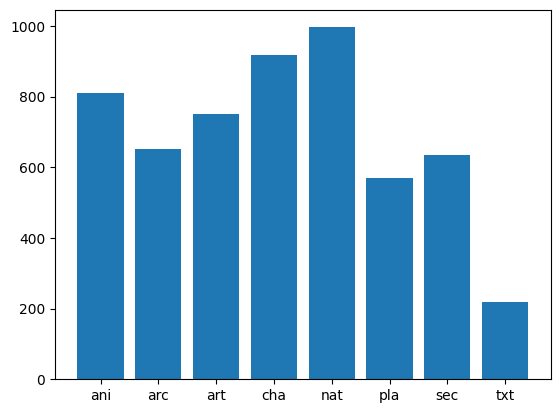

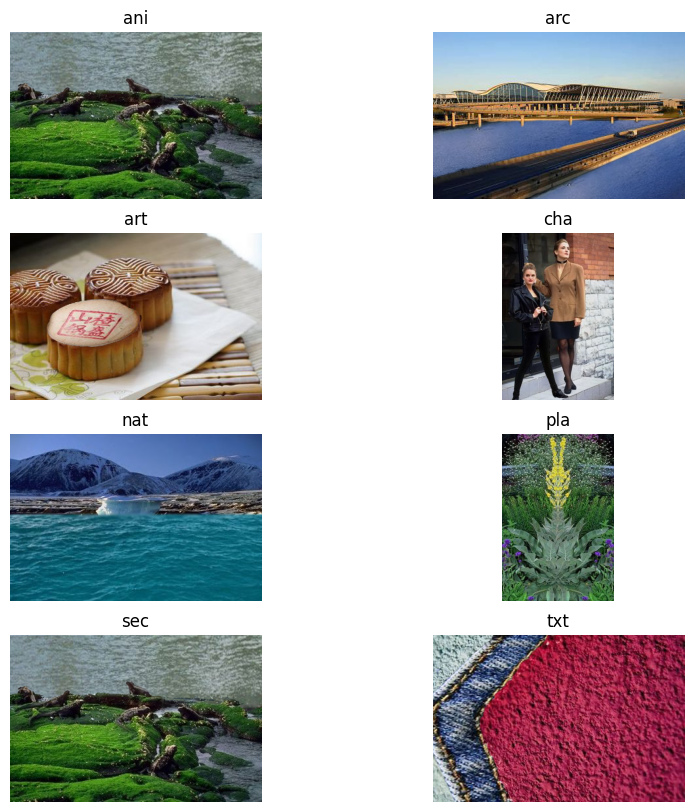

In [45]:
dicc_fake = create_category_dictionary(FAKE_IMAGE_PATH)

print("Number of fake images: ", count_files(FAKE_IMAGE_PATH))
print("Number of categories: ", len(dicc_fake))
plot_dictionary(dicc_fake)

show_image_from_category(FAKE_IMAGE_PATH, dicc_fake)

### Analyzing type of Tampering in the images

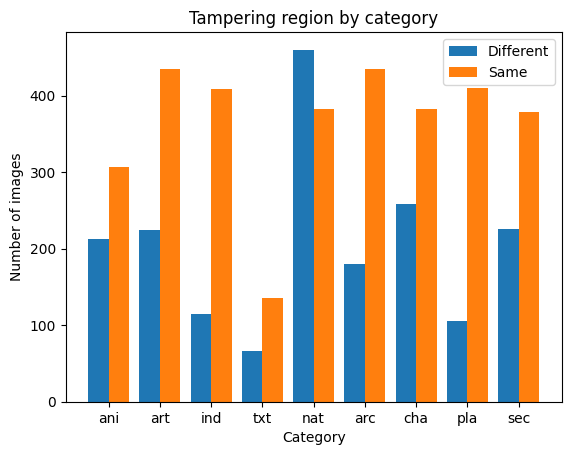

In [46]:
dicc_tp = create_trampering_dictionary(FAKE_IMAGE_PATH)
multiple_bar_plots(dicc_tp)

## Solving problms related to the dataset

Debido a que la categoria textil no es muy amplia lo mejor sera eliminarlo tanto de las imagenes falsas como de las reales

In [47]:
cabezera = "category", "image", "real"
df_au = pd.DataFrame(columns=cabezera)

for idx, file in enumerate(os.listdir(REAL_IMAGE_PATH)):
    img = cv2.imread(os.path.join(REAL_IMAGE_PATH, file))
    img_np = np.array(img)
    category = file.split("_")

    df_au = pd.concat([df_au, pd.DataFrame([[category[1], img_np, 1]], columns=cabezera)], ignore_index=True)

df_au.head()


,category,image,real
0,ani,"[[[227, 186, 77], [224, 183, 74], [221, 179, 7...",1
1,ani,"[[[158, 132, 118], [162, 136, 122], [154, 129,...",1
2,ani,"[[[0, 6, 6], [0, 11, 9], [4, 15, 13], [14, 28,...",1
3,ani,"[[[40, 19, 21], [40, 19, 21], [39, 21, 22], [3...",1
4,ani,"[[[79, 21, 9], [80, 22, 10], [80, 22, 10], [80...",1


In [48]:
#remove categoriy txt because it is not in the dataset
df_au = df_au[df_au.category != "txt"]
df_au = df_au[df_au.category != "ind"]
#mezclar el dataframe
df_au = df_au.sample(frac=1).reset_index(drop=True)

In [49]:
#mezclar el dataframe
df_au = df_au.sample(frac=1).reset_index(drop=True)

In [50]:
df_au.head()

,category,image,real
0,arc,"[[[109, 8, 0], [110, 9, 0], [112, 11, 2], [112...",1
1,nat,"[[[46, 135, 119], [39, 128, 109], [36, 124, 10...",1
2,cha,"[[[49, 64, 80], [51, 66, 82], [52, 67, 83], [4...",1
3,arc,"[[[110, 85, 51], [111, 86, 52], [115, 90, 56],...",1
4,ani,"[[[9, 33, 57], [16, 40, 64], [33, 57, 79], [49...",1


In [51]:
#cogemos 600 imagenes de cada categoria
df_au = df_au.groupby('category').head(600)
#muestra el numero de imagenes por categoria
df_au.groupby('category').size()

category
ani    600
arc    600
art    600
cha    600
nat    600
pla    600
sec    600
dtype: int64

Realizaremos el mismo proceso con las imagenes modificadas

In [52]:
cabezera = "category", "image", "region", "real"
key_list = ["ani", "arc", "art", "cha", "nat", "pla", "sec"]
df_tp = pd.DataFrame(columns=cabezera)

for file in os.listdir(FAKE_IMAGE_PATH):
    #convert image to np array
    img = cv2.imread(os.path.join(FAKE_IMAGE_PATH, file))
    img_np = np.array(img)
    category = file.split("_")
    category[5] = category[5][:3]
    df_tp = pd.concat([df_tp, pd.DataFrame([[category[5], img_np, category[1], 0]], columns=cabezera)], ignore_index=True)

df_tp.head()

,category,image,region,real
0,ani,"[[[197, 173, 153], [198, 174, 154], [196, 172,...",D,0
1,art,"[[[9, 13, 18], [9, 13, 18], [8, 12, 17], [8, 1...",D,0
2,art,"[[[189, 181, 181], [187, 179, 179], [168, 166,...",D,0
3,ani,"[[[49, 79, 60], [66, 96, 77], [64, 90, 77], [6...",D,0
4,ind,"[[[9, 14, 12], [9, 14, 12], [12, 14, 14], [17,...",D,0


In [53]:
df_tp = df_tp[df_tp.category != "txt"]
df_tp = df_tp[df_tp.category != "ind"]
df_tp = df_tp.sample(frac=1).reset_index(drop=True)

In [54]:
df_tp.head()

,category,image,region,real
0,arc,"[[[212, 209, 204], [212, 209, 204], [212, 209,...",D,0
1,arc,"[[[12, 20, 20], [13, 21, 21], [15, 23, 23], [1...",S,0
2,nat,"[[[74, 90, 113], [63, 77, 99], [71, 86, 105], ...",D,0
3,nat,"[[[197, 137, 101], [195, 135, 99], [153, 91, 5...",S,0
4,cha,"[[[105, 96, 6], [100, 91, 1], [98, 90, 0], [10...",S,0


In [55]:
#cogemos 600 imagenes de cada categoria pero 300 de cada region
df_tp = df_tp.groupby(['category', 'region']).head(300)
#muestra el numero de imagenes por categoria
df_tp.groupby(['category', 'region']).size()

category  region
ani       D         213
          S         300
arc       D         180
          S         300
art       D         225
          S         300
cha       D         259
          S         300
nat       D         300
          S         300
pla       D         105
          S         300
sec       D         226
          S         300
dtype: int64

## Re-analyzing the dataset

Text(0.5, 1.0, 'Total Real images by category')

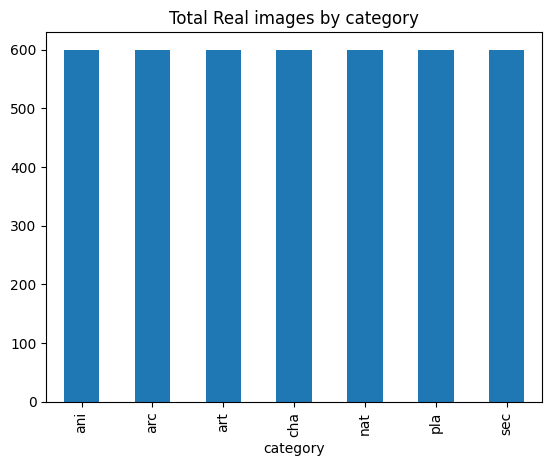

In [56]:
#plot cantidad de imagenes por categoria
#with y label "Quantity of images"
df_au.groupby('category').size().plot(kind='bar').set_title("Total Real images by category")

In [57]:
def multiple_bar_plots_df(dataframe: pd.DataFrame) -> None:
    x = dataframe['category'].unique()
    x_axis = np.arange(len(x))
    d = []
    s = []
    for key in x:
        d.append(dataframe[dataframe['category'] == key]['region'].value_counts()['D'])
        s.append(dataframe[dataframe['category'] == key]['region'].value_counts()['S'])

    plt.bar(x_axis - 0.2, d, 0.4, label='Different')
    plt.bar(x_axis + 0.2, s, 0.4, label='Same')
    
    plt.xticks(x_axis, x)
    plt.xlabel("Category")
    plt.ylabel("Number of images")
    plt.title("Tampering region by category")
    
    plt.legend()
    plt.show()

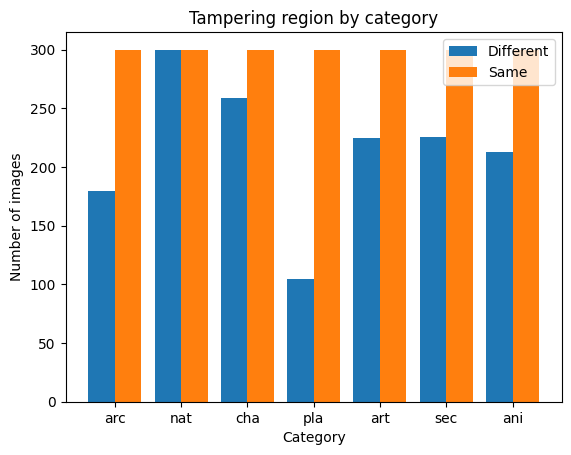

In [58]:
multiple_bar_plots_df(df_tp)